## Populate the Spotify Ontology

In [1]:
# required libraries
#!pip install rdflib
import pandas as pd
import os
from pathlib import Path
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import FOAF, XSD
from datetime import datetime
from rdflib.namespace import OWL, RDFS
import folium
import plotly.express as px



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 7.6 MB/s eta 0:00:00


In [2]:
# Construct the country and the spotify ontology namespaces not known by RDFlib
CNS = Namespace("http://eulersharp.sourceforge.net/2003/03swap/countries#")
SP = Namespace("http://www.dei.unipd.it/GraphDatabases/SpotifyOntology#")



In [5]:
# parameters and URLs
path = str(Path(os.path.abspath(os.getcwd())).parent.absolute())

# #spotify codes

spotify = os.path.join(path, 'INDEX', 'spotify', 'dataset', 'updated_data_cleaning.csv')
#spotify = "/content/drive/MyDrive/GraphDB/updated_data_cleaning.csv"

# saving folder

savePath =  path + '/INDEX/spotify/dataset/rdf/'
#savePath = "/content/drive/MyDrive/GraphDB/"


## Country

In [6]:


# Load the CSV file into a pandas DataFrame
spotify_data = pd.read_csv(spotify)

# Extract unique regions as countries, ensuring no duplicates
Countries = spotify_data[['region']].drop_duplicates().rename(columns={'region': 'country_name'})



In [7]:
#create the graph
g = Graph()

# Bind the namespaces to a prefix for more readable output
g.bind("foaf", FOAF)
g.bind("xsd", XSD)
g.bind("countries", CNS)
g.bind("sp", SP)


In [8]:
%%time
# Initialize a counter for country IDs starting from 1
country_counter = 1

#create dictionary of countries to link them with charts
dict_of_countries = {}

# Iterate over the unique country names
for _, row in Countries.iterrows():
    # Create the node to add to the Graph with a sequential ID
    Country = URIRef(SP['country' + str(country_counter)])

    dict_of_countries[row['country_name']] = Country

    # Add triples using store's add() method
    g.add((Country, RDF.type, SP.Country))
    g.add((Country, SP['region'], Literal(row['country_name'], datatype=XSD.string)))

    # Increment the counter for the next country
    country_counter += 1


CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 14.2 ms


In [9]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'country.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))


--- saving serialization ---
CPU times: user 12.5 ms, sys: 249 µs, total: 12.7 ms
Wall time: 21.4 ms


## Top 10 Countries by Total Streams

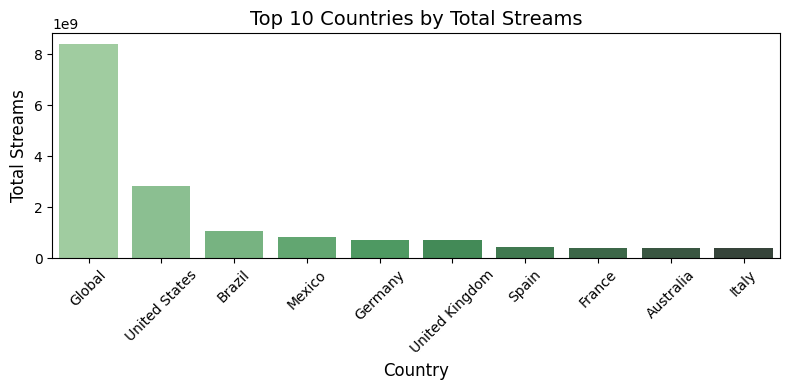

In [10]:

# Load Spotify data
spotify_data = pd.read_csv(spotify)

# Calculate total streams by country and get the top 10 countries
top_10_countries = (
    spotify_data.groupby('region')['streams']
    .sum()
    .nlargest(10)
    .reset_index()  # Ensure the result is a DataFrame
)
top_10_countries.columns = ['Country', 'Total Streams']  # Rename columns for clarity

# Visualize the top 10 countries by total streams
plt.figure(figsize=(8, 4))
# sns.barplot(data=top_10_countries, x='Country', y='Total Streams', palette='Greens_d')
sns.barplot(data=top_10_countries, x='Country', y='Total Streams', hue='Country', palette='Greens_d', dodge=False, legend=False)
plt.title('Top 10 Countries by Total Streams', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Streams', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


## Number of Songs by Country

In [11]:

# Load the dataset
spotify_data = pd.read_csv(spotify)

# GeoJSON file for country boundaries
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
world_geo = f'{url}/world-countries.json'

# Count the number of songs for each country
country_counts = spotify_data['region'].value_counts().reset_index()
country_counts.columns = ['Country', 'Number of Songs']

# Normalize country names to lowercase
country_counts['Country'] = country_counts['Country'].str.lower()

# Get the number of songs for Argentina (default to 0 if not found)
if 'argentina' in country_counts['Country'].values:
    argentina_songs = country_counts.loc[country_counts['Country'] == 'argentina', 'Number of Songs'].values[0]
else:
    argentina_songs = 0

# Create a base map
m = folium.Map(location=[0, 0], zoom_start=2)

# Add a choropleth layer
folium.Choropleth(
    geo_data=world_geo,
    name='choropleth',
    data=country_counts,
    columns=['Country', 'Number of Songs'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.4,
    line_opacity=0.2,
    legend_name='Number of Songs by Country'
).add_to(m)

# Add a marker for Argentina with the number of songs
folium.Marker(
    location=[-38.4161, -63.6167],  # Coordinates for Argentina
    popup=f'Argentina: {argentina_songs} Songs',
    tooltip='Click for more info',
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

display(m)


## Artist

In [13]:
#create the graph
g = Graph()

# Bind the namespaces to a prefix for more readable output
g.bind("foaf", FOAF)
g.bind("xsd", XSD)
g.bind("countries", CNS)
g.bind("so", SP)

g.add((SP.Artist, SP['SubClassOf'], FOAF.Person))

dict_of_artists = {}

# Extract unique artists from the dataset
# Process the artists
artists = spotify_data['artist'].unique()  # Get unique artists

for index, artist in enumerate(artists):
    # Create a unique URI for each artist
    artist_id = f"artist{index + 1}"  # ID starts from 1
    Artist = URIRef(SP[artist_id])

    dict_of_artists[artist] = Artist

    # Add triples for the artist
    g.add((Artist, RDF.type, SP.Artist))  # Declare as an Artist
    g.add((Artist, FOAF.name, Literal(artist, datatype=XSD.string)))  # Add name

In [14]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'artist.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---
CPU times: user 1.83 s, sys: 1.11 ms, total: 1.84 s
Wall time: 1.89 s


## Top Taylor Swift Song by Total Streams in Each Country

In [15]:

# Load the Spotify dataset
spotify_data = pd.read_csv(spotify)

# Filter dataset for songs by Taylor Swift
taylor_songs = spotify_data[spotify_data['artist'] == 'Taylor Swift']

# Group data by song title and country, and calculate total streams
top_song_streams = taylor_songs.groupby(['title', 'region'])['streams'].sum().reset_index()

# Select the top song with the highest stream count for each country
top_song_per_country = top_song_streams.loc[top_song_streams.groupby('region')['streams'].idxmax()]

# Visualize the data on a geographical map
fig = px.scatter_geo(
    top_song_per_country,
    locations='region',  # Country names from the 'region' column
    locationmode='country names',  # Match country names to map locations
    color='streams',  # Color based on total streams
    hover_name='title',  # Show song title on hover
    size='streams',  # Bubble size based on total streams
    projection='natural earth',  # Natural Earth projection
    title='Top Taylor Swift Song by Total Streams in Each Country'
)

# Show the visualization
fig.show()


## Song

In [16]:
# Create RDF graph
g = Graph()
g.bind("spotify", SP)
g.bind("countries", CNS)

songs = spotify_data[['title', 'url', 'artist']].drop_duplicates()   # Get unique song titles, urls and corresponding artists

dict_of_songs = {}

# Process the songs
for index, row in songs.iterrows():
    # Create a unique URI for each song
    song_id = f"song{index + 1}"  # ID starts from 1
    Song = URIRef(SP[song_id])

    # Add triples for the song
    g.add((Song, RDF.type, SP.Song))  # Declare as a Song
    g.add((Song, SP['songUrl'], Literal(row['url'], datatype=XSD.string)))  # Add song URL
    g.add((Song, SP['songName'], Literal(row['title'], datatype=XSD.string))) # Add song title

    # Add url and URI of the song to the dictionary of songs
    dict_of_songs[row['url']] = Song

    # Link the song to the artist
    g.add((Song, SP['performedBy'], dict_of_artists[row['artist']]))

In [17]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'song.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---
CPU times: user 5.87 s, sys: 16.7 ms, total: 5.89 s
Wall time: 6.09 s


## Chart

In [18]:
# Create RDF graph
g = Graph()
g.bind("countries", CNS)
g.bind("spotify", SP)

g.add((SP.Top200, SP['SubClassOf'], SP.Chart))
g.add((SP.Viral50, SP['SubClassOf'], SP.Chart))

chart_counter = 1

#dictionary that has tuples of the chart's uri and chart's type and country
dict_of_charts = {}

#for every country we create viral50 chart and top200 chart
for _, row in Countries.iterrows():
  country_name = row['country_name']
  #create top 200 chart
  Chart200 = URIRef(SP[f'chart{chart_counter}'])

  g.add((Chart200, RDF.type, SP.Chart))
  g.add((Chart200, RDF.type, SP.Top200))
  g.add((Chart200, SP['chartType'], Literal("top200", datatype=XSD.string)))
  #get uri of the country from the dictionary of countries
  g.add((Chart200, SP['publishedIn'], dict_of_countries[country_name]))

  type_country_200 = "top200" + country_name
  #add tuple to the dictionary
  dict_of_charts[type_country_200] = Chart200

  chart_counter += 1

  #create viral 50 chart
  Chart50 = URIRef(SP[f'chart{chart_counter}'])

  g.add((Chart50, RDF.type, SP.Chart))
  g.add((Chart50, RDF.type, SP.Viral50))
  g.add((Chart50, SP['chartType'], Literal("viral50", datatype=XSD.string)))
  #get uri of the country from the dictionary of countries
  g.add((Chart50, SP['publishedIn'], dict_of_countries[country_name]))

  type_country_50 = "viral50" + country_name
  #add tuple to the dictionary
  dict_of_charts[type_country_50] = Chart50

  chart_counter += 1


In [19]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'chart.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---
CPU times: user 40.9 ms, sys: 820 µs, total: 41.8 ms
Wall time: 81.6 ms


## RankedRecord

In [21]:
# Create RDF graph
g = Graph()
g.bind("spotify", SP)

from datetime import datetime

# Define trendStatus values
trend_status_values = {
    "MOVE_UP": SP.MOVE_UP,
    "MOVE_DOWN": SP.MOVE_DOWN,
    "SAME_POSITION": SP.SAME_POSITION,
    "NEW_ENTRY": SP.NEW_ENTRY,
}

# Rename the rank column to RankedRecord
spotify_data.rename(columns={"rank": "RankedRecord"}, inplace=True)

for index, row in spotify_data.iterrows():
    try:
        # Create a unique URI for each rank
        rank_id = f"rankedRecord{index + 1}"  # Unique ID for each rank
        Rank = URIRef(SP[rank_id])

        # Add triples for the rank
        g.add((Rank, RDF.type, SP.RankedRecord))  # Declare as a Rank
        g.add((Rank, SP['hasRank'], Literal(int(row['RankedRecord']), datatype=XSD.integer)))  # Add rank position

        g.add((Rank, SP['date'], Literal(row['date'], datatype=XSD.date)))  # Add date

        #get uri of chart from the dictionary
        type_country = row['chart'] + row['region']
        Chart = dict_of_charts[type_country]

        # Link the rank to the unique chart
        g.add((Rank, SP['associatedWithChart'], Chart))  # Link rank to the unique chart ID

        Song = dict_of_songs[row['url']]

        g.add((Rank, SP['assignedToSong'], Song))  # Link rank to song

        # Add trendStatus
        trend_status = trend_status_values.get(row['trend'])
        if trend_status:
            g.add((Rank, SP['trendStatus'], trend_status))  # Add trend status

        # Add stream count if available
        if pd.notna(row['streams']):
            g.add((Rank, SP['streamCount'], Literal(int(row['streams']), datatype=XSD.integer)))  # Add stream count


    except ValueError as e:
        print(f"Skipping row {index} due to error: {e}")
        continue  # Skip rows with issues

In [22]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'RankedRecord.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---
CPU times: user 3min 27s, sys: 1.37 s, total: 3min 29s
Wall time: 3min 31s


## Number of Songs Released per Year

year
2017    114253
2018    121419
2019    136521
2020    147522
Name: title, dtype: int64


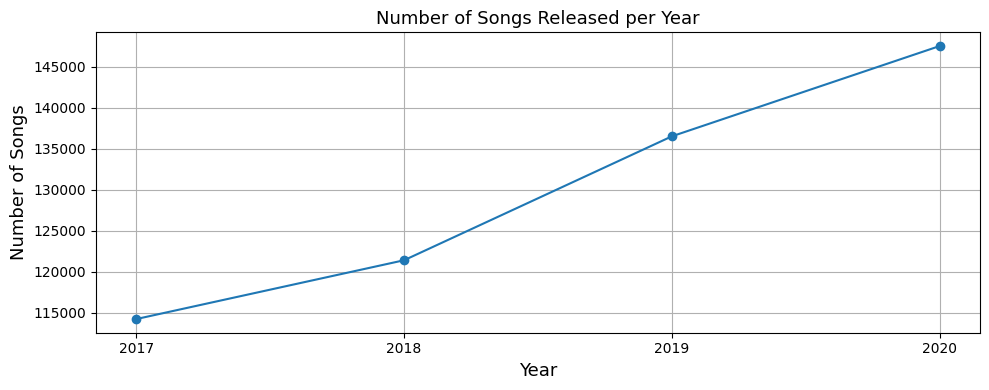

In [23]:


# Load your Spotify dataset
df_spotify = pd.read_csv(spotify)

# Convert the 'date' column to datetime type
df_spotify['date'] = pd.to_datetime(df_spotify['date'], errors='coerce')

# Extract the year from the 'date' column
df_spotify['year'] = df_spotify['date'].dt.year

# Group by year and count the number of songs for each year
count_per_year = df_spotify.groupby('year').count()['title']

# Display the count per year
print(count_per_year)

# Plot the number of songs released per year
plt.figure(figsize=(10, 4))
plt.plot(count_per_year.index, count_per_year.values, marker='o')

# Add title and labels
plt.title('Number of Songs Released per Year', fontsize=13)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Songs', fontsize=13)

# Customize the grid and ticks
plt.xticks(np.arange(count_per_year.index.min(), count_per_year.index.max() + 1, 1))
plt.grid(True)
plt.tight_layout()

# Apply Seaborn styling
sns.set_style('whitegrid')

# Show the plot
plt.show()


## Total Streams per Year

year
2017    3.819058e+09
2018    4.793464e+09
2019    5.509889e+09
2020    6.614654e+09
Name: streams, dtype: float64


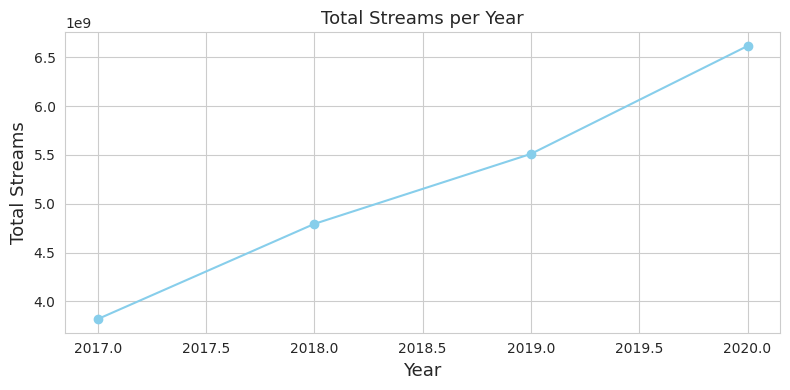

In [24]:

# Load Spotify CSV
df_spotify = pd.read_csv(spotify)

# Convert 'date' column to datetime type
df_spotify['date'] = pd.to_datetime(df_spotify['date'], errors='coerce')

# Extract the 'year' from the 'date' column
df_spotify['year'] = df_spotify['date'].dt.year

# Filter for Top200 chart songs (since only they have stream_count)
df_spotify_top200 = df_spotify[df_spotify['chart'] == 'top200']

# Group by year and calculate the total stream_count
total_streams_per_year = df_spotify_top200.groupby('year')['streams'].sum()

# Print the total streams per year
print(total_streams_per_year)

# Plot total streams per year
plt.figure(figsize=(8, 4))
total_streams_per_year.plot(marker='o', color='skyblue')
plt.title('Total Streams per Year', fontsize=13)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Total Streams', fontsize=13)
plt.grid(True)
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()


## Top 10 songs that have most often been top 1 on the Top 200 chart

In [25]:
# Load Spotify CSV
df_spotify = pd.read_csv(spotify)

# Convert 'date' column to datetime type
df_spotify['date'] = pd.to_datetime(df_spotify['date'], errors='coerce')

# Extract the 'year' from the 'date' column
df_spotify['year'] = df_spotify['date'].dt.year

# Filter for Top200 chart songs
df_spotify_top200 = df_spotify[df_spotify['chart'] == 'top200']

# Filter for Top200 chart songs that were Top 1 in the chart
df_spotify_top200_pos1 = df_spotify_top200[df_spotify_top200['rank'] == 1]

# Group by title, calculate the number of times a song appears at #1 on the chart, sort and get the top 10
top200_10_songs_top1 = df_spotify_top200_pos1.groupby(['title', 'artist'])['title'].count().sort_values(ascending=False).head(10)

# Print 10 most frequent songs and the number of times a song has appeared at number one on the chart
print(top200_10_songs_top1)


title                                          artist                
Dance Monkey                                   Tones And I               193
Shape of You                                   Ed Sheeran                185
Tusa                                           KAROL G, Nicki Minaj      168
rockstar                                       Post Malone, 21 Savage     93
Wow.                                           Post Malone                88
Calma - Remix                                  Pedro Capo, Farruko        86
Reggaeton Lento (Bailemos)                     CNCO                       79
Sunflower - Spider-Man: Into the Spider-Verse  Post Malone, Swae Lee      69
Starboy                                        The Weeknd, Daft Punk      66
Dejala Que Vuelva (feat. Manuel Turizo)        Piso 21                    65
Name: title, dtype: int64


## Top 10 most frequent songs in the Viral 50 chart

In [26]:
# Load Spotify CSV
df_spotify = pd.read_csv(spotify)

# Convert 'date' column to datetime type
df_spotify['date'] = pd.to_datetime(df_spotify['date'], errors='coerce')

# Extract the 'year' from the 'date' column
df_spotify['year'] = df_spotify['date'].dt.year

# Filter for Viral 50 chart songs
df_spotify_viral50 = df_spotify[df_spotify['chart'] == 'viral50']

# Group by title and artist, calculate the number of times a song appears in the chart, sort and get the top 10
viral50_frequent_10_songs = df_spotify_viral50.groupby(['title', 'artist'])['title'].count().sort_values(ascending=False).head(10)

# Print 10 most frequent songs, corresponding artists and the number of times a song has appeared in the chart
print(viral50_frequent_10_songs)

title                                            artist             
Falling                                          Trevor Daniel          652
Nothing Breaks Like a Heart (feat. Miley Cyrus)  Mark Ronson            644
No Idea                                          Don Toliver            637
thank u, next                                    Ariana Grande          630
The Box                                          Roddy Ricch            624
Blinding Lights                                  The Weeknd             623
Calma - Remix                                    Pedro Capo, Farruko    597
ROXANNE                                          Arizona Zervas         588
Ayy Macarena                                     Tyga                   575
Adore You                                        Harry Styles           558
Name: title, dtype: int64


## Top 10 Songs by Streams per Year

In [36]:
# Assume the dataset is loaded in `df_spotify`
# Convert the 'date' column to datetime format
df_spotify['date'] = pd.to_datetime(df_spotify['date'], errors='coerce')

# Add a 'year' column from the date
df_spotify['year'] = df_spotify['date'].dt.year

df_spotify = df_spotify.dropna()

# Select the row with the highest number of streams for each song
df_spotify_unique = df_spotify.loc[df_spotify.groupby('title')['streams'].idxmax()]

# Filter the data to keep only necessary columns and remove the year 2022
filtered_data = df_spotify_unique[['title', 'artist', 'streams', 'year']]
# Get the top 10 songs for each year
top_songs_by_year = (
    filtered_data.sort_values(by=['year', 'streams'], ascending=[True, False])  # Sort by year and streams
    .groupby('year')
    .head(10)
)

# Display the data in a table without index
from IPython.display import display
display(top_songs_by_year.reset_index(drop=True))




,title,artist,streams,year
0,Shape of You,Ed Sheeran,7261007.0,2017
1,Castle on the Hill,Ed Sheeran,5661820.0,2017
2,Starboy,"The Weeknd, Daft Punk",3619247.0,2017
3,Closer,"The Chainsmokers, Halsey",3224594.0,2017
4,I Dont Wanna Live Forever (Fifty Shades Darker...,"ZAYN, Taylor Swift",3157514.0,2017
5,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,3094116.0,2017
6,Let Me Love You,"DJ Snake, Justin Bieber",2680096.0,2017
7,Say You Won't Let Go,James Arthur,2636733.0,2017
8,Don't Wanna Know,"Maroon 5, Kendrick Lamar",2599826.0,2017
9,I Feel It Coming,"The Weeknd, Daft Punk",2512007.0,2017


## Top 5 artists with the most nominated songs in the Top 200 each year

In [31]:
# Convert the 'date' column to datetime format
df_spotify['date'] = pd.to_datetime(df_spotify['date'], errors='coerce')

# Add a 'year' column from the date
df_spotify['year'] = df_spotify['date'].dt.year

# Filter the data for songs in the Top 200 chart
top_200_data = df_spotify[df_spotify['chart'] == 'top200']

# Remove duplicate songs for each artist based on 'title' within the same year
unique_songs = top_200_data.drop_duplicates(subset=['title', 'year'])

# Count the number of unique songs for each artist in the Top 200 for each year
artist_unique_song_counts = (
    unique_songs.groupby(['year', 'artist'])
    .size()
    .reset_index(name='unique_song_count')
)

# Get the top 10 artists for each year based on unique song count
top_artists_by_year = (
    artist_unique_song_counts.sort_values(by=['year', 'unique_song_count'], ascending=[True, False])
    .groupby('year')
    .head(5)
)

# Display the results in a table
from IPython.display import display
display(top_artists_by_year.reset_index(drop=True))





,year,artist,unique_song_count
0,2017,Ed Sheeran,26
1,2017,PNL,16
2,2017,Jul,15
3,2017,Piruka,15
4,2017,The Weeknd,15
5,2018,Ed Sheeran,23
6,2018,Gulddreng,17
7,2018,Orelsan,14
8,2018,Ektor,13
9,2018,France Gall,13


## Top 5 Most Streamed Songs

Table: Top 5 Most Streamed Songs


title,artist,streams
Shape of You,Ed Sheeran,"145,174,291"
Dance Monkey,Tones And I,"139,045,382"
Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee","122,565,268"
"thank u, next",Ariana Grande,"98,219,252"
Wow.,Post Malone,"97,953,001"


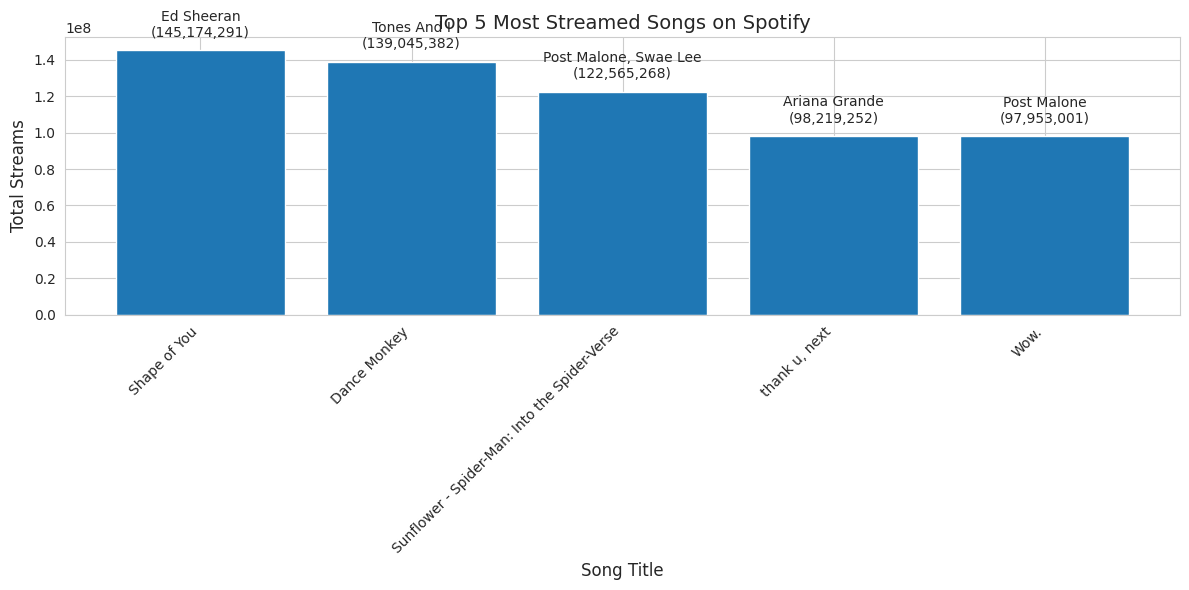

In [34]:
# Convert the 'date' column to datetime format
df_spotify['date'] = pd.to_datetime(df_spotify['date'], errors='coerce')

# Add a 'year' column from the date
df_spotify['year'] = df_spotify['date'].dt.year

# Filter the data for songs in the Top 200 chart
top_200_data = df_spotify[df_spotify['chart'] == 'top200']

# Group by 'title' and 'artist', then sum the streams
top_streamed_songs = (
    top_200_data.groupby(['title', 'artist'])['streams']
    .sum()
    .reset_index()
    .sort_values(by='streams', ascending=False)
    .head(5)
)

# Format streams for better readability
top_streamed_songs['streams'] = top_streamed_songs['streams'].apply(lambda x: f"{x:,.0f}")

# Display the formatted table
from IPython.display import display
print("Table: Top 5 Most Streamed Songs")
display(top_streamed_songs.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '14px'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('font-size', '12px'), ('text-align', 'center')]}]
).hide(axis='index'))

# Convert 'streams' column back to integers for plotting
top_streamed_songs['streams'] = top_streamed_songs['streams'].str.replace(',', '').astype(int)

# Wrap long song titles
#top_streamed_songs['title'] = top_streamed_songs['title'].apply(lambda x: "\n".join(wrap(x, width=30)))

plt.figure(figsize=(12, 6))

# Plot vertical bars
bars = plt.bar(
    x=top_streamed_songs['title'],
    height=top_streamed_songs['streams'],
)

# Add annotations for each bar
for bar, streams, artist in zip(bars, top_streamed_songs['streams'], top_streamed_songs['artist']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05 * max(top_streamed_songs['streams']),
        f"{artist}\n({streams:,})",
        ha='center',
        fontsize=10
    )

plt.ylabel('Total Streams', fontsize=12)
plt.xlabel('Song Title', fontsize=12)
plt.title('Top 5 Most Streamed Songs on Spotify', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()



## Dataset Cleaning

In [ ]:
import pandas as pd
import unicodedata

# Function to normalize text
def normalize_text(text):
    if isinstance(text, str):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', errors='ignore')
    return text

# Read the dataset from file
file_path = '/INDEX/spotify/dataset/chart.csv'
spotify_df = pd.read_csv(file_path)

# Clean the song titles and artist names
spotify_df['title'] = spotify_df['title'].apply(normalize_text)
spotify_df['artist'] = spotify_df['artist'].apply(normalize_text)

# Remove unnecessary columns (if any)
if 'Unnamed: 9' in spotify_df.columns:
    spotify_df = spotify_df.drop(columns=['Unnamed: 9'])

# Save the cleaned dataset
save_path = r'/INDEX/spotify/dataset/cleaned_chart.csv'
spotify_df.to_csv(save_path, index=False)

# Print success message
print("Data cleaning has been successfully completed.")


Data cleaning has been successfully completed.
